In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import sys
import os
import json
import pandas as pd
from IPython.display import clear_output

sys.path.insert(0, '/home/garren/HPC Files/Pure RK PMF')

from Post_procs import Post_process

/tmp/ipykernel_796942/2769480865.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
functional_groups = np.array(['all'])
include_clusters = True
include_zeros = True
refT = True
ARD = False
inf_type = 'MAP'

In [3]:
post_obj = Post_process(include_clusters=include_clusters,
                        include_zeros=include_zeros,
                        refT=refT,
                        ARD=ARD,
                        inf_type=inf_type,
                        functional_groups=functional_groups)

In [4]:
A_pure = post_obj.get_tensors()

In [5]:
pure_rank_idx = np.where(post_obj.ranks==9)[0][0]
err_dict_pure = post_obj.get_testing_metrics(A=A_pure)
data_dict_pure = post_obj.get_testing_values(A=A_pure)

In [6]:
y_MC_interps = post_obj.extract_interps(A=A_pure, Idx=post_obj.testing_indices)

In [7]:
sys.path.remove('/home/garren/HPC Files/Pure RK PMF')
del sys.modules['Post_procs']

sys.path.insert(0, '/home/garren/HPC Files/Hybrid PMF Adj')

from Post_procs import Post_process

In [8]:
post_obj = Post_process(include_clusters=include_clusters,
                        include_zeros=include_zeros,
                        ARD=ARD,
                        inf_type=inf_type,
                        functional_groups=functional_groups)

In [9]:
A_hybrid = post_obj.get_tensors()

In [10]:
hybrid_rank_idx = np.where(post_obj.ranks==2)[0][0]
err_dict_hybrid = post_obj.get_testing_metrics(A=A_hybrid)
data_dict_hybrid = post_obj.get_testing_values(A=A_hybrid)

In [11]:
c_all = post_obj.c_all
Idx_known = post_obj.Idx_known
testing_indices = post_obj.testing_indices

In [12]:
p12, p21 = post_obj.extract_params(A=A_hybrid, Idx=testing_indices)

In [13]:
matplotlib.use('qt5agg')
%matplotlib inline

In [14]:
def excess_enthalpy_predictions(x, T, p12, p21, a=0.3):
    # Function to compute the excess enthalpy predictions
    if p12.ndim > 1:
        if p12.ndim == 2:
            x = x[:, np.newaxis]
        elif p12.ndim == 3:
            x = x[:, np.newaxis, np.newaxis]
        if not np.isscalar(T):
            if p12.ndim == 2:
                T = T[:, np.newaxis]
            elif p12.ndim == 3:
                T = T[:, np.newaxis, np.newaxis]
        if p12.ndim == 2:
            t12 = p12[:,0][np.newaxis,:] + p12[:,1][np.newaxis,:] * T + p12[:,2][np.newaxis,:] / T + p12[:,3][np.newaxis,:] * np.log(T)
            t21 = p21[:,0][np.newaxis,:] + p21[:,1][np.newaxis,:] * T + p21[:,2][np.newaxis,:] / T + p21[:,3][np.newaxis,:] * np.log(T)
            dt12_dT = p12[:,1][np.newaxis,:] - p12[:,2][np.newaxis,:] / T**2 + p12[:,3][np.newaxis,:] / T
            dt21_dT = p21[:,1][np.newaxis,:] - p21[:,2][np.newaxis,:] / T**2 + p21[:,3][np.newaxis,:] / T
        elif p12.ndim == 3:
            t12 = p12[:,:,0][np.newaxis,:,:] + p12[:,:,1][np.newaxis,:,:] * T + p12[:,:,2][np.newaxis,:,:] / T + p12[:,:,3][np.newaxis,:,:] * np.log(T)
            t21 = p21[:,:,0][np.newaxis,:,:] + p21[:,:,1][np.newaxis,:,:] * T + p21[:,:,2][np.newaxis,:,:] / T + p21[:,:,3][np.newaxis,:,:] * np.log(T)
            dt12_dT = p12[:,:,1][np.newaxis,:,:] - p12[:,:,2][np.newaxis,:,:] / T**2 + p12[:,:,3][np.newaxis,:,:] / T
            dt21_dT = p21[:,:,1][np.newaxis,:,:] - p21[:,:,2][np.newaxis,:,:] / T**2 + p21[:,:,3][np.newaxis,:,:] / T

    else:
        t12 = p12[0] + p12[1] * T + p12[2] / T + p12[3] * np.log(T)
        t21 = p21[0] + p21[1] * T + p21[2] / T + p21[3] * np.log(T)
        dt12_dT = p12[1] - p12[2] / T**2 + p12[3] / T
        dt21_dT = p21[1] - p21[2] / T**2 + p21[3] / T

    G12 = np.exp(-a*t12)
    G21 = np.exp(-a*t21)

    term1 = ( ( (1-x) * G12 * (1 - a*t12) + x * G12**2 ) / ((1-x) + x * G12)**2 ) * dt12_dT
    term2 = ( ( x * G21 * (1 - a*t21) + (1-x) * G21**2 ) / (x + (1-x) * G21)**2 ) * dt21_dT
    
    # if dims p12 = 1, return 1D array of size N_points
    # if dims p12 = 2, return 2D array of size N_points x p12.shape[0]
    # if dims p12 = 3, return 3D array of size N_points x p12.shape[0] x p12.shape[1]
    return -8.314 * T**2 * x * (1-x) * ( term1 + term2 )

In [15]:
Kx = lambda x1, x2: np.column_stack([np.column_stack([x1**(i+2)-x1 for i in range(3)]), 
                                1e-1*x1*np.sqrt(1-x1)*np.exp(x1)]) @ np.column_stack([np.column_stack([x2**(i+2)-x2 for i in range(3)]), 
                                                                                    1e-1*x2*np.sqrt(1-x2)*np.exp(x2)]).T
KT = lambda T1, T2: np.column_stack([np.ones_like(T1), T1, T1**2, 1e-3*T1**3]) @ np.column_stack([np.ones_like(T2), T2, T2**2, 1e-3*T2**3]).T
K = lambda x1, x2, T1, T2: Kx(x1, x2) * KT(T1, T2)

In [16]:
data_file_pure = '/home/garren/HPC Files/Pure RK PMF/Subsets/all/data.json'
data_file_hybrid = '/home/garren/HPC Files/Hybrid PMF Adj/Subsets/all/data.json'


In [17]:
x2_int = np.array(json.load(open(data_file_pure, 'r'))['x2_int'])
T2_int = np.array(json.load(open(data_file_pure, 'r'))['T2_int'])
v_MC = json.load(open(data_file_pure, 'r'))['v_MC']
jitter = json.load(open(data_file_pure, 'r'))['jitter']

x_MC = np.concatenate([x2_int for _ in T2_int])
T_MC = np.concatenate([t*np.ones_like(x2_int) for t in T2_int])

K_MC = K(x_MC, x_MC, T_MC, T_MC) + (jitter+v_MC)*np.eye(len(x_MC))
L_MC = np.linalg.cholesky(K_MC)
L_MC_inv = np.linalg.inv(L_MC)
K_MC_inv = L_MC_inv.T @ L_MC_inv

del L_MC, L_MC_inv, K_MC

In [18]:
scaling = np.array(json.load(open(data_file_hybrid, 'r'))['scaling'])

In [19]:
N_points = np.array(json.load(open(data_file_hybrid, 'r'))['N_points'])
x = np.array(json.load(open(data_file_hybrid, 'r'))['x'])
T = np.array(json.load(open(data_file_hybrid, 'r'))['T'])
y = np.array(json.load(open(data_file_hybrid, 'r'))['y'])

In [20]:
exp_mix = np.char.add(np.char.add(data_dict_hybrid['c1'], ' + '), data_dict_hybrid['c2'])

In [44]:
df_UNIFAC = pd.read_excel(post_obj.excel_plots_known, sheet_name='Testing_Plots')
uni_mix = np.char.add(np.char.add(df_UNIFAC['Component 1'].to_numpy().astype(str), ' + '), df_UNIFAC['Component 2'].to_numpy().astype(str))

In [23]:
plot_path = '/home/garren/HPC Files/Comparison of Hybrid and Pure'
os.makedirs(plot_path, exist_ok=True)

In [ ]:
# Use Agg for saving a lot of plots without opening figure window
matplotlib.use('Agg')

#initialize by closing all open figures
plt.clf()
plt.close()

In [117]:
fits = f'{plot_path}/2D Plots/Testing'
os.makedirs(fits, exist_ok=True)

for i in range(len(testing_indices)):
    mixi = f'{c_all[testing_indices[i,0]]} + {c_all[testing_indices[i,1]]}'
    mix_idx = exp_mix == mixi
    mix_uni_idx = uni_mix == mixi

    p12_plot = p12[hybrid_rank_idx,:,i]
    p21_plot = p21[hybrid_rank_idx,:,i]

    x_plot = np.linspace(0,1,101)

    xx = data_dict_hybrid['x'][mix_idx]
    TT = data_dict_hybrid['T'][mix_idx]
    yy_exp = data_dict_hybrid['y_exp'][mix_idx]

    xx_uni = df_UNIFAC['Composition component 1 [mol/mol]'].to_numpy()[mix_uni_idx]
    TT_uni = df_UNIFAC['Temperature [K]'].to_numpy()[mix_uni_idx]
    yy_uni = df_UNIFAC['UNIFAC_DMD [J/mol]'].to_numpy()[mix_uni_idx]

    T_unique = np.unique(TT)
    T_unique = np.concatenate([T_unique.astype(int)+0.15, T_unique.astype(int)+1.15])
    T_unique = np.unique(T_unique)

    T_unique = T_unique[np.sum(np.abs(T_unique[:,np.newaxis] - TT[np.newaxis,:]) <= 0.5, axis=1) > 0]

    for j in range(len(T_unique)):
        fig, ax = plt.subplots()

        T_idx = np.abs(TT-T_unique[j])<=0.5
        T_idx_uni = np.abs(TT_uni-T_unique[j])<=0.5

        x_y = xx[T_idx]
        y_y = yy_exp[T_idx]
        x_uni = xx_uni[T_idx_uni]
        y_uni = yy_uni[T_idx_uni]

        K_plot_MC = K(x_plot, x_MC, T_unique[j]*np.ones_like(x_plot), T_MC)
        y_MC_pure = K_plot_MC @ K_MC_inv @ y_MC_interps[pure_rank_idx][:,i]

        y_hybrid = excess_enthalpy_predictions(x_plot, T_unique[j], p12_plot, p21_plot)

        ax.plot(x_plot, y_MC_pure, '-r', label='Pure MC Rank 9')
        ax.plot(x_plot, y_hybrid, '-b', label='Hybrid MC Rank 2')
        ax.plot(x_uni, y_uni, '-g', label='UNIFAC')
        ax.plot(x_y, y_y, '.k', label='Experimental Data')

        c1 = mixi.split(' + ')[0]
        c2 = mixi.split(' + ')[1]
        ax.set_title(f'(1) {c1} + (2) {c2} at {T_unique[j]} K', fontsize=13)
        ax.set_xlabel('Composition of Component 1 [mol/mol]',fontsize=13)
        ax.set_ylabel('Excess Enthalpy [J/mol]',fontsize=18)
        ax.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=10)
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tight_layout()

        png_path = f'{fits}/{i}_{j}.png'
        plt.savefig(png_path, dpi=300)

        plt.close('all')
        clear_output(wait=False)

        print(f'{i}_{j}.png saved')

        plt.clf()
        plt.close()

211_0.png saved


In [21]:
MAE_pure = err_dict_pure['MC', 'MAE', 9][:-1]
MAE_hybrid = err_dict_hybrid['MC', 'MAE', 2][:-1]

RMSE_pure = err_dict_pure['MC', 'RMSE', 9][:-1]
RMSE_hybrid = err_dict_hybrid['MC', 'RMSE', 2][:-1]

MARE_pure = err_dict_pure['MC', 'MARE', 9][:-1]
MARE_hybrid = err_dict_hybrid['MC', 'MARE', 2][:-1]

all_err_metrics = {'MAE': [MAE_pure, MAE_hybrid],
                   'RMSE': [RMSE_pure, RMSE_hybrid],
                   'MARE': [MARE_pure, MARE_hybrid]}

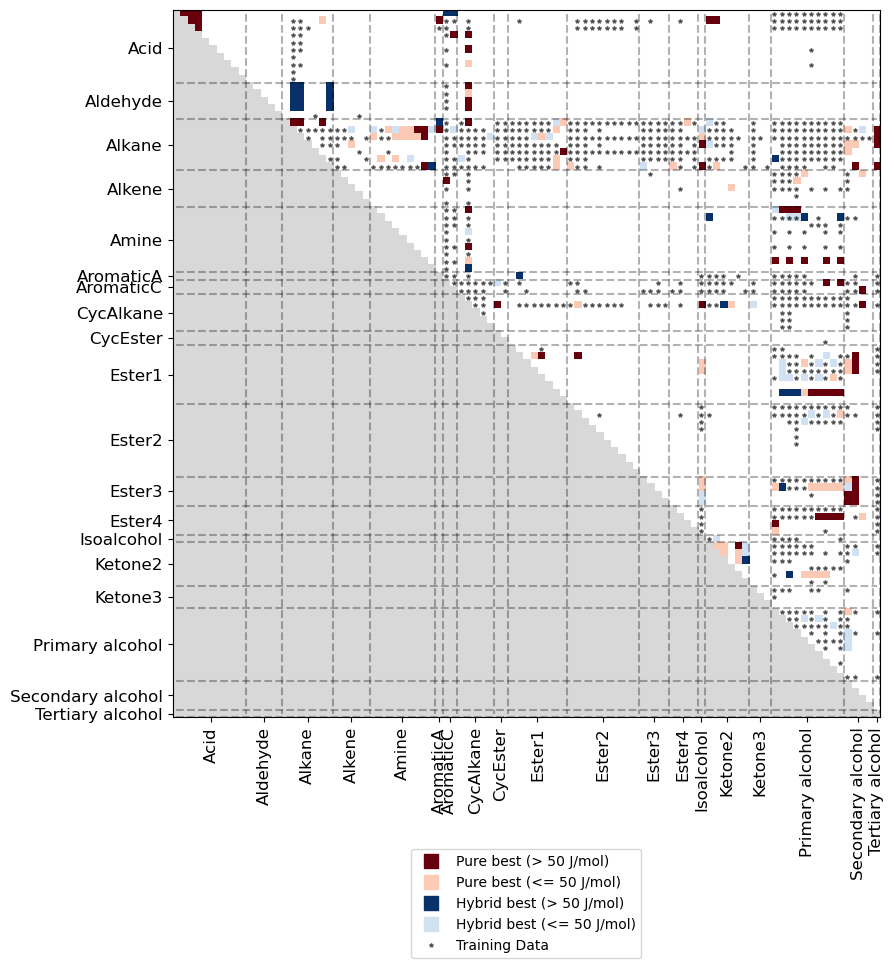

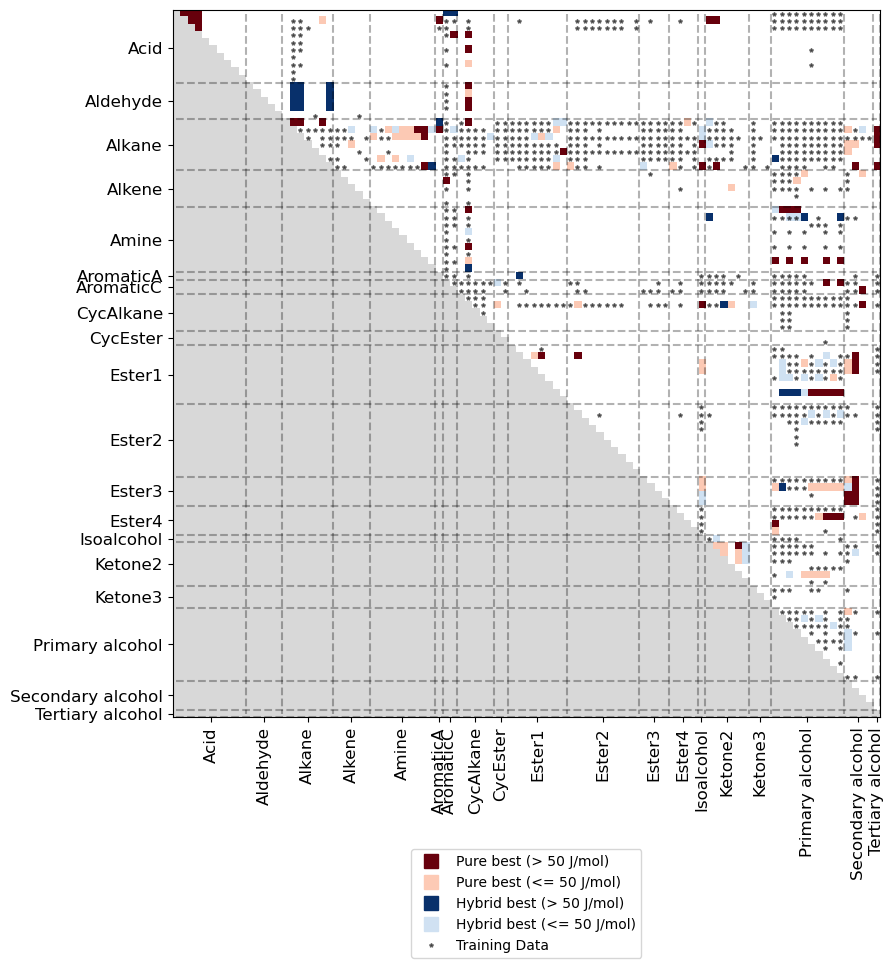

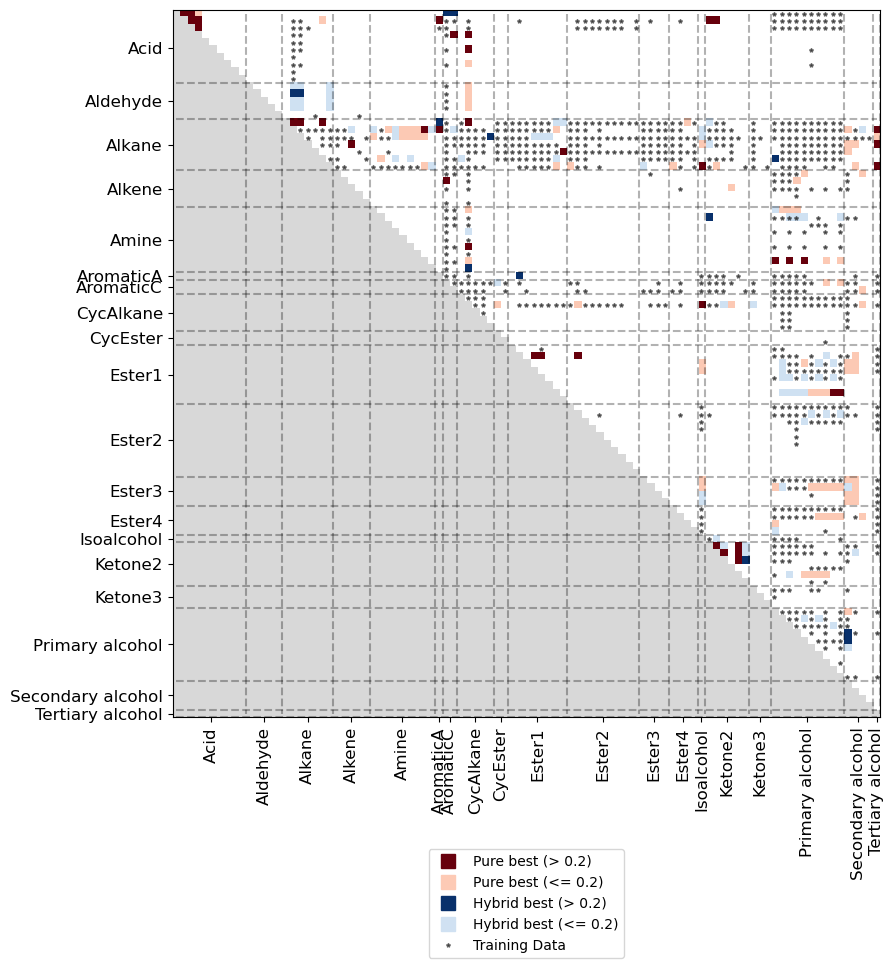

In [25]:
err_metrics = ['RMSE', 'MAE', 'MARE']
N = json.load(open(post_obj.data_file, 'r'))['N']
AE_MC = np.nan*np.eye(N)
AE_uni = np.nan*np.eye(N)

for err_metric in err_metrics:
    if err_metric == 'MARE':
        cutoff = 0.2
        legend_low = f'(<= {cutoff})'
        legend_high = f'(> {cutoff})'
    else:
        cutoff = 50
        legend_low = f'(<= {cutoff} J/mol)'
        legend_high = f'(> {cutoff} J/mol)'
        
    diff_metrics = np.array(all_err_metrics[err_metric][0] - all_err_metrics[err_metric][1])

    uni_best = diff_metrics>0
    MC_best = ~uni_best

    diff_metrics = np.abs(diff_metrics)
    diff_metrics[diff_metrics <= cutoff] = 0.2
    diff_metrics[diff_metrics > cutoff] = 1

    AE_MC[post_obj.testing_indices[MC_best,0], post_obj.testing_indices[MC_best,1]] = diff_metrics[MC_best]
    AE_uni[post_obj.testing_indices[uni_best,0], post_obj.testing_indices[uni_best,1]] = diff_metrics[uni_best]

    plt.figure(figsize=(10, 10))

    plt.plot(post_obj.Idx_known[:,1], post_obj.Idx_known[:,0], '*k', label='Training Data', alpha=0.5, markersize=3)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), fontsize=12)

    plt.imshow(AE_MC, cmap='Reds', vmin=0, vmax=1, label='MC')
    plt.imshow(AE_uni, cmap='Blues', vmin=0, vmax=1, label='UNIFAC')

    A_grey = np.nan*np.eye(N)
    for i in range(N):
        for j in range(i,N):
            A_grey[j,i] = 0.25
        
    plt.imshow(A_grey, cmap='Greys',vmin=0,vmax=1)

    unique_fg, idx, counts = np.unique(post_obj.fg, return_index=True, return_counts=True)
    unique_fg = unique_fg[np.argsort(idx)]
    counts = counts[np.argsort(idx)]
    counts[0]=counts[0]-1
    counts = counts

    end_points = [0]
    for count in np.cumsum(counts):
        count += 0.5
        end_points += [count]
        plt.plot([count, count], [0, N-1], '--k', alpha=0.3)
        plt.plot([0, N-1], [count, count], '--k', alpha=0.3)

    mid_points = (np.array(end_points[:-1])+np.array(end_points[1:]))/2
    plt.xticks(mid_points, unique_fg, rotation=90, fontsize=12)
    plt.yticks(mid_points, unique_fg, fontsize=12)

    # Custom legend elements
    # Get colors from colormaps
    red_alpha_1 = cm.Reds(0.9999)  # Dark red
    red_alpha_2 = cm.Reds(0.2)  # Light red
    green_alpha_1 = cm.Blues(0.9999)  # Dark green
    green_alpha_2 = cm.Blues(0.2)  # Light green

    # Custom legend elements
    custom_lines = [
        Line2D([0], [0], marker='s', color=red_alpha_1, markersize=10, label=f'Pure best {legend_high}', linestyle=''),
        Line2D([0], [0], marker='s', color=red_alpha_2, markersize=10, label=f'Pure best {legend_low}', linestyle=''),
        Line2D([0], [0], marker='s', color=green_alpha_1, markersize=10, label=f'Hybrid best {legend_high}', linestyle=''),
        Line2D([0], [0], marker='s', color=green_alpha_2, markersize=10, label=f'Hybrid best {legend_low}', linestyle=''),
        Line2D([0], [0], marker='*', color='k', markersize=3, alpha=0.5, label='Training Data', linestyle=''),
    ]
    # Add legend to the plot
    plt.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(0.5, -0.35))

    plt.tight_layout()

    png_path = f'{plot_path}/{err_metric}.png'

    plt.savefig(png_path, dpi=500)